# Finding Unused Trial Vaults

Minecraft 1.21 has been out for a while now, and even though I don't generally go for combat, I've been having fun playing in the new Trial Chambers.

I've been eschewing [Chunkbase](https://www.chunkbase.com/apps/seed-map) in favor of getting maps to the chambers legit using cartographers, even though it's a pain in the toucans since each villager is, in effect, single-use. Given that level of hassle, before ramping up a breeder setup, I figure I should be checking in with how efficiently I'm using the chambers I've already generated. That is: how many chambers that I've already explored _still have_ vaults that I haven't opened?

## Setup, Imports and Macros

In [1]:
import json
import re
from collections import Counter, defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed
from os import environ
from pathlib import Path
from typing import Any, Collection, Iterable

import matplotlib.pyplot as plt
import mutf8
import pandas as pd
from IPython.display import Markdown, display
from nbt import nbt, region

/tmp/ipykernel_267338/1950360014.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def summarize_keystore(keystore: dict[str, Any]) -> None:
    """Display a summary of the contents of a key-value store

    Parameters
    ----------
    keystore : dict
        The keystore to summarize

    Returns
    -------
    None
    """

    def _summarize_keystore(keystore: dict[str, Any]) -> str:
        summary = ""
        for k, v in keystore.items():
            summary += f"\n - `{k}` : "
            if isinstance(v, (str, nbt.TAG_String)):
                summary += f'`"{v}"`'
            elif not isinstance(v, Collection):
                summary += f"`{str(v)}`"
            else:
                length = len(v)
                if 0 < length < 3:
                    summary += "\n"
                    if not isinstance(v, dict):
                        v = {i: item for i, item in enumerate(v)}
                    summary += "\n".join(
                        (f"\t{line}" for line in _summarize_keystore(v).split("\n"))
                    )
                else:
                    summary += f"({len(v)} items)"
        return summary

    display(Markdown(_summarize_keystore(keystore)))

In [3]:
save_folder = Path(environ["SAVE_PATH"])
assert save_folder.exists()
region_files = sorted(
    (save_folder / "region").glob("*.mca"), key=lambda path: -path.stat().st_size
)

## Pull Up Some Vault Data

We're going to start with one that I know exactly where it is.

![BetterF3 of known vault](../_static/vault.png)

I'm also calling it now: I'd be shocked if they're not considered "block entities."

In [4]:
vaulty_chunk = region.RegionFile(save_folder / "region" / "r.-4.-8.mca").get_chunk(
    2, 23
)
display(
    Markdown(
        "Types of block entities in chunk:\n"
        + "\n".join(
            {
                "  - {}".format(entity["id"].value)
                for entity in vaulty_chunk["block_entities"]
            }
        )
    )
)

Types of block entities in chunk:
  - minecraft:vault
  - minecraft:mob_spawner

Cool cool.

In [5]:
vaults = [
    entity
    for entity in vaulty_chunk["block_entities"]
    if entity["id"].value == "minecraft:vault"
]
print(f"There are {len(vaults)} vaults in this chunk")

There are 1 vaults in this chunk


In [6]:
summarize_keystore(vaults[0])


 - `z` : `-3717`
 - `server_data` : 
	
	 - `0` : `"state_updating_resumes_at"`
	 - `1` : `"rewarded_players"`
 - `x` : `-2007`
 - `config` : 
	
	 - `0` : `"loot_table"`
	 - `1` : `"key_item"`
 - `id` : `"minecraft:vault"`
 - `y` : `-11`
 - `keepPacked` : `0`
 - `shared_data` : (0 items)

In [7]:
type(vaults[0]["server_data"]["rewarded_players"])

nbt.nbt.TAG_List

In [8]:
type(vaults[0]["server_data"]["rewarded_players"][0])

nbt.nbt.TAG_Int_Array

Okay, so "is it used?" is just storing my UUID. But also: this is a single-player world, and while I do open it to LAN to let my kid join me on adventures, they have (so far) not been interested in tackling a trial chamber, so the whole question of "is it used?" can be answered simply by asking, "is `rewarded_players` empty?"

In [9]:
def is_used(vault: nbt.TAG_Compound) -> bool:
    """Determine if a vault has been used

    Parameters
    ----------
    vault : block entity
        The block entity corresponding to the vault

    Returns
    -------
    bool
        True if this vault has rewarded a player,
        False otherwise
    """
    if "rewarded_players" not in vault["server_data"]:
        return False  # possibly YAGNI, but better safe
    return len(vault["server_data"]["rewarded_players"]) > 0

### How can I tell if it's ominous?

This should be front-and-center, given that `ominous=true/false` appears in F3. But looking at the data that's available...

In [10]:
summarize_keystore(vaults[0]["config"]["key_item"])


 - `id` : `"minecraft:ominous_trial_key"`
 - `count` : `1`

The fact that this is configurable makes me wonder if you can generate a vault with an _arbitrary_ unlock item (which would be awesome), but for what I'm here for, my question is answered:

In [11]:
def is_ominous(vault: nbt.TAG_Compound) -> bool:
    """Determine if a vault is ominous

    Parameters
    ----------
    vault : block entity
        The block entity corresponding to the vault

    Returns
    -------
    bool
        True if it requires an ominous key to unlock,
        False otherwise
    """
    return vault["config"]["key_item"]["id"].value == "minecraft:ominous_trial_key"

## Search for Unused Vaults

In [12]:
def find_vaults(region_file: Path) -> list[tuple[tuple[int, int, int], bool, bool]]:
    """Find all vaults in a region

                                Parameters
                                ----------
                                region_file : Path
                                    The region to search

                                Returns
                                -------
                                list of tuples, where each element consists of:
                                    - tuple of three ints: (x, y, z) coordinates of the vault
    - bool: is the vault ominous?
    - bool: has the vault been used?
    """
    vaults = []
    for chunk in region.RegionFile(region_file).iter_chunks():
        for vault in chunk["block_entities"]:
            if vault["id"].value != "minecraft:vault":
                continue  # then it's not a vault
            vaults.append(
                (
                    (vault["x"].value, vault["y"].value, vault["z"].value),
                    is_ominous(vault),
                    is_used(vault),
                )
            )
    return vaults

In [13]:
%%time
futures = []
all_vaults = []
with ProcessPoolExecutor(max_workers=24) as executor:
    for path in region_files:
        futures.append(executor.submit(find_vaults, path))

for result in as_completed(futures):
    all_vaults.extend(result.result())

print(
    f"Found {len(all_vaults)} vaults"
    f", {sum((vault[1] for vault in all_vaults))} of them ominous"
    f", {sum((vault[2] for vault in all_vaults))} of them used"
    f" and {sum((vault[1] and not vault[2] for vault in all_vaults))} unused ominous"
)

Found 639 vaults, 217 of them ominous, 54 of them used and 194 unused ominous
CPU times: user 74.7 ms, sys: 63.2 ms, total: 138 ms
Wall time: 11.1 s


This may sound like a lot, but that's because I've almost certainly generated chambers I haven't visited, so I want to narrow this down by just looking at unused vaults near used vaults.

In [14]:
def calculate_distance(
    loc_1: tuple[int, int, int], loc_2: tuple[int, int, int]
) -> float:
    """Calculate the horizontal distance between two locations

    Parameters
    ----------
    loc_1 : tuple of three ints
        The first location
    loc_2 : tule of three ints
        The second location

    Returns
    -------
    float
        the horizontal distance between the two locations

    Note
    ----
    I don't believe trial vaults can spawn _on top_ of each other,
    but they definitely have a lot of verticality that I could
    have missed in my exploration. Hence why I'm only using
    horizontal distance.
    """
    return ((loc_1[0] - loc_2[0]) ** 2 + (loc_1[2] - loc_2[2]) ** 2) ** 0.5

Now, there are smart ways I could optimize the following search, but for the scale of the problem (there are only 54 used vaults), doing it "dumb" is going to be good enough (and I'll throw in a `%%time` to prove it.

In [15]:
# this could also be optimized
unused_vaults = [vault for vault in all_vaults if not vault[2]]
used_vaults = [vault for vault in all_vaults if vault[2]]

In [16]:
def is_near_used_vault(
    vault: tuple[tuple[int, int, int], bool, bool], threshold: float = 32.0
) -> bool:
    """Determine if a vault is near a used vault

    Parameters
    ----------
    vault : tuple
        Extracted data on a vault
    threshold : float, optional
        The threshold to use to determine what qualifies as "near."
        Default is 32.

    Returns
    -------
    bool
        Whether that vault is near a used vault
    """
    return any(
        (
            calculate_distance(vault[0], used_vault[0]) < threshold
            for used_vault in used_vaults
        )
    )

In [17]:
%%time
near_used = [is_near_used_vault(vault) for vault in unused_vaults]
print(f"There are {sum(near_used)} unused vaults in proximity to used vaults")

There are 20 unused vaults in proximity to used vaults
CPU times: user 6.16 ms, sys: 0 ns, total: 6.16 ms
Wall time: 6.12 ms


Let's make sure we chose a good threshold.

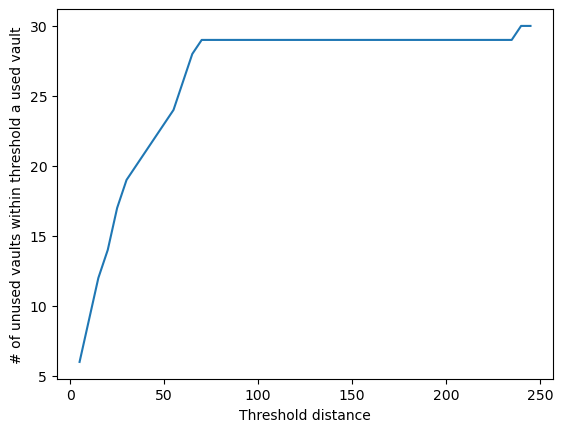

In [18]:
# again, we're performing **so many** unnessecary calculations
# (we could have just computed _once_ the min distance from each vault
# to a used vault), but we're not dealing at a scale where that level
# of optimization makes sense
threshold_data = []
for threshold in range(5, 250, 5):
    threshold_data.append(
        (
            threshold,
            sum((is_near_used_vault(vault, threshold)) for vault in unused_vaults),
        )
    )

fig, ax = plt.subplots()
ax.plot(*zip(*threshold_data))
ax.set_xlabel("Threshold distance")
ax.set_ylabel("# of unused vaults within threshold a used vault")
plt.show(fig)

Ohh that's interesting. That is, the vaults are a lot bigger than I was expecting, and the proper threshold (where the curve levels off) is probably more like 60 or 70.

In [19]:
threshold_df = pd.DataFrame(
    threshold_data, columns=["Threshold", "Unused Explored Vaults"]
)
display(
    threshold_df.loc[threshold_df.Threshold > 50]
    .loc[threshold_df.Threshold < 100]
    .set_index("Threshold")
)

,Unused Explored Vaults
Threshold,
55,24
60,26
65,28
70,29
75,29
80,29
85,29
90,29
95,29


Yeah, so the curve completely levels off after 70, which—wow! 70 blocks is _far away!_

In [20]:
for vault in unused_vaults:
    if not is_near_used_vault(vault, threshold=70):
        continue
    print(
        "There is an unused {} vault at ({}, {}, {})".format(
            "ominous" if vault[1] else "regular", *vault[0]
        )
    )

There is an unused regular vault at (97, -37, -3206)
There is an unused regular vault at (107, -37, -3206)
There is an unused regular vault at (102, -39, -3197)
There is an unused regular vault at (106, -44, -3179)
There is an unused ominous vault at (114, -33, -3189)
There is an unused regular vault at (169, -25, -3212)
There is an unused regular vault at (198, -32, -3221)
There is an unused regular vault at (301, -23, -3540)
There is an unused ominous vault at (313, 5, -3579)
There is an unused regular vault at (-2043, -14, -3751)
There is an unused ominous vault at (-2031, -23, -3738)
There is an unused ominous vault at (-2007, -16, -3691)
There is an unused regular vault at (-2012, -21, -3691)
There is an unused regular vault at (-1982, -14, -3765)
There is an unused ominous vault at (-1425, -25, -6259)
There is an unused regular vault at (-1430, -30, -6259)
There is an unused regular vault at (-1429, -30, -6268)
There is an unused regular vault at (-1420, -30, -6267)
There is an u